<h1>Groupwork submission 2</h1>

<h1>Importing relevant Libraries here</h1>

In [62]:
import pandas as pd
import numpy as np
import datetime as dt
from arch import arch_model
from arch.univariate import ARCHInMean,GARCH
from datetime import datetime
import matplotlib.pyplot as plt
# !pip install pandas_datareader
from pandas_datareader import data,wb
pd.options.mode.chained_assignment = None 
from statsmodels.tsa.stattools import adfuller, coint
from arch.unitroot import engle_granger
from statsmodels.tsa.vector_ar.vecm import select_coint_rank, VECM
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson

%matplotlib inline

<h1>0. Data Selection</h1>

For this work, we'll be using the <b>Goldman Sachs Physical Gold ETF (AAAU)</b> which is traded in USD as the gold ETF. 

Our choice for equity ETF is the <b>iShares VII Public Limited Company - iShares Nikkei</b> which is traded in GBp in LSE (London Stock Exchange )

Third instrument of concern will be bitcoin for us

The source of the dataset is <a href='https://finance.yahoo.com'>Yahoo Finane</a>

<h1>1. Data Importing</h1>

In [63]:
#writing a helper function which takes in the ticker and returns data set

def get_data(ticker,database='yahoo'):
    start = dt.datetime(2020,1,1)
    end = dt.datetime(2020,12,31)
    return data.DataReader(ticker,database,start,end)

In [64]:
print("gold_etf_data i.e. AAAU data ")
gold_etf_data=get_data("AAAU")
print(gold_etf_data.head(2))
print(gold_etf_data.tail(2))

gold_etf_data i.e. AAAU data 
             High    Low   Open  Close  Volume  Adj Close
Date                                                     
2019-12-31  15.21  15.15  15.19  15.15  169000      15.15
2020-01-02  15.28  15.20  15.24  15.25   43100      15.25
                 High    Low       Open      Close  Volume  Adj Close
Date                                                                 
2020-12-30  18.870001  18.73  18.740000  18.870001  400200  18.870001
2020-12-31  18.940001  18.83  18.889999  18.940001  282500  18.940001


In [65]:
print("equity_etf_data i.e. CNKY.L data ")
equity_etf_data=get_data("CNKY.L")
print(equity_etf_data.head(2))
print(equity_etf_data.tail(2))

equity_etf_data i.e. CNKY.L data 
                    High      Low     Open    Close  Volume  Adj Close
Date                                                                  
2019-12-31  15434.000000  15434.0  15434.0  15434.0       0    15434.0
2020-01-02  15679.442383  15646.0  15674.0  15725.0    1091    15725.0
                    High      Low     Open    Close  Volume  Adj Close
Date                                                                  
2020-12-30  18909.119141  18769.0  18769.0  18802.5     550    18802.5
2020-12-31  18773.000000  18691.0  18694.0  18703.5     619    18703.5


In [66]:
print("bitcoin_data i.e. BTC-USD data ")
bitcoin_data=get_data("BTC-USD")
print(bitcoin_data.head(2))
print(bitcoin_data.tail(2))

bitcoin_data i.e. BTC-USD data 
                   High          Low         Open        Close       Volume  \
Date                                                                          
2019-12-31  7335.290039  7169.777832  7294.438965  7193.599121  21167946112   
2020-01-01  7254.330566  7174.944336  7194.892090  7200.174316  18565664997   

              Adj Close  
Date                     
2019-12-31  7193.599121  
2020-01-01  7200.174316  
                    High           Low          Open         Close  \
Date                                                                 
2020-12-30  28937.740234  27360.089844  27360.089844  28840.953125   
2020-12-31  29244.876953  28201.992188  28841.574219  29001.720703   

                 Volume     Adj Close  
Date                                   
2020-12-30  51287442704  28840.953125  
2020-12-31  46754964848  29001.720703  


In [67]:
def get_3_quarters_data(data):
    return data[data.index.to_series().between('2020-04-01','2020-12-31')]

In [68]:
print("gold_etf_data for 3 quarters i.e. AAAU data ")
gold_etf_3_quarters=get_3_quarters_data(gold_etf_data)
print(gold_etf_3_quarters.head())
print(gold_etf_3_quarters.tail())
print("\n")
print("\n")
print("equity_etf_data for 3 quarters i.e. AAAU data ")
equity_etf_3_quarters=get_3_quarters_data(equity_etf_data)
print(equity_etf_3_quarters.head())
print(equity_etf_3_quarters.tail())
print("\n")
print("\n")

print("bitcoin_data for 3 quarters i.e. AAAU data ")
bitcoin_3_quarters=get_3_quarters_data(bitcoin_data)
print(bitcoin_3_quarters.head())
print(bitcoin_3_quarters.tail())

gold_etf_data for 3 quarters i.e. AAAU data 
                 High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2020-04-01  16.160000  15.680000  15.740000  15.870000  296200  15.870000
2020-04-02  16.209999  15.990000  16.209999  16.180000   99200  16.180000
2020-04-03  16.230000  16.080000  16.150000  16.180000  160300  16.180000
2020-04-06  16.650000  16.320000  16.400000  16.650000  334600  16.650000
2020-04-07  16.549999  16.379999  16.480000  16.540001  214000  16.540001
                 High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2020-12-24  18.719999  18.629999  18.650000  18.709999  168100  18.709999
2020-12-28  18.879999  18.639999  18.799999  18.660000  487900  18.660000
2020-12-29  18.780001  18.650000  18.700001  18.709999  432600  18.709999
2020-12-30  18.870001  18.730000  18.740000  18.870001  400200  18.

<h1>2. Data Processing</h1>

In [69]:
def calculate_daily_returns(df):
    df['Daily_Return'] = df["Adj Close"].pct_change(1)
    return df

In [70]:
print("gold_etf_data With daily Returns i.e. AAAU data ")
gold_etf_3_quarters=calculate_daily_returns(gold_etf_3_quarters)
print(gold_etf_3_quarters.head())
print(gold_etf_3_quarters.tail())
print("\n")
print("\n")

print("equity_etf_data With daily Returns i.e. AAAU data ")
equity_etf_3_quarters=calculate_daily_returns(equity_etf_3_quarters)
print(equity_etf_3_quarters.head())
print(equity_etf_3_quarters.tail())
print("\n")
print("\n")


print("bitcoin_data With daily Returns i.e. AAAU data ")
bitcoin_3_quarters=calculate_daily_returns(bitcoin_3_quarters)
print(bitcoin_3_quarters.head())
print(bitcoin_3_quarters.tail())
print("\n")
print("\n")

gold_etf_data With daily Returns i.e. AAAU data 
                 High        Low       Open      Close  Volume  Adj Close  \
Date                                                                        
2020-04-01  16.160000  15.680000  15.740000  15.870000  296200  15.870000   
2020-04-02  16.209999  15.990000  16.209999  16.180000   99200  16.180000   
2020-04-03  16.230000  16.080000  16.150000  16.180000  160300  16.180000   
2020-04-06  16.650000  16.320000  16.400000  16.650000  334600  16.650000   
2020-04-07  16.549999  16.379999  16.480000  16.540001  214000  16.540001   

            Daily_Return  
Date                      
2020-04-01           NaN  
2020-04-02      0.019534  
2020-04-03      0.000000  
2020-04-06      0.029048  
2020-04-07     -0.006607  
                 High        Low       Open      Close  Volume  Adj Close  \
Date                                                                        
2020-12-24  18.719999  18.629999  18.650000  18.709999  168100  18.7

<h1>3. Data Summaries</h1>

In [71]:
def get_3_quarters_data_with_data_for_moving_average(data):
    return data[data.index.to_series().between('2020-03-01','2020-12-31')]

window=20
def compute_moving_average(df_input):
    df=df_input.copy(deep = True)
    df['MovingAvg']=0.0
    date_index = pd.Series(df.index)
    #print(date_index)
    rolling_windows = date_index.rolling(window)
    for a_window in rolling_windows:
        if(len(a_window) == window):
            a_window.index=range(len(a_window))
            ts=a_window[len(a_window)-1]
            val=df[df.index.isin(a_window)]['Adj Close'].mean()
            df.at[ts,'MovingAvg']=val
    #df=df[df['MovingAvg'].notna()]
    #df=df[df['Adj Close'].notna()]
    return df

In [72]:

print("gold_etf_data for 3 quarters i.e. AAAU data ")
gold_etf_3_quarters_with_data_for_moving_average=get_3_quarters_data_with_data_for_moving_average(gold_etf_data)
print(gold_etf_3_quarters_with_data_for_moving_average.head())
print(gold_etf_3_quarters_with_data_for_moving_average.tail())

print("\n")
print("\n")
print("equity_etf_data for 3 quarters")
equity_etf_3_quarters_with_data_for_moving_average=get_3_quarters_data_with_data_for_moving_average(equity_etf_data)
print(equity_etf_3_quarters_with_data_for_moving_average.head())
print(equity_etf_3_quarters_with_data_for_moving_average.tail())
print("\n")
print("\n")

print("bitcoin_data for 3 quarters ")
bitcoin_3_quarters_with_data_for_moving_average=get_3_quarters_data_with_data_for_moving_average(bitcoin_data)
print(bitcoin_3_quarters_with_data_for_moving_average.head())
print(bitcoin_3_quarters_with_data_for_moving_average.tail())


gold_etf_data for 3 quarters i.e. AAAU data 
                 High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2020-03-02  15.970000  15.800000  15.900000  15.810000  293900  15.810000
2020-03-03  16.420000  15.980000  15.990000  16.309999  256700  16.309999
2020-03-04  16.410000  16.299999  16.370001  16.340000  293000  16.340000
2020-03-05  16.709999  16.510000  16.559999  16.690001  181100  16.690001
2020-03-06  16.850000  16.389999  16.790001  16.690001  311400  16.690001
                 High        Low       Open      Close  Volume  Adj Close
Date                                                                     
2020-12-24  18.719999  18.629999  18.650000  18.709999  168100  18.709999
2020-12-28  18.879999  18.639999  18.799999  18.660000  487900  18.660000
2020-12-29  18.780001  18.650000  18.700001  18.709999  432600  18.709999
2020-12-30  18.870001  18.730000  18.740000  18.870001  400200  18.

gold_etf moving averages data for 3 quarters


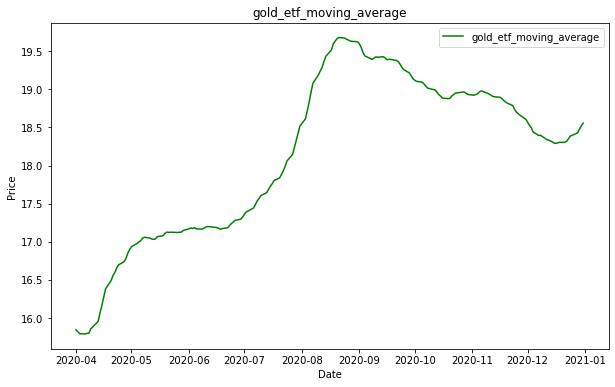

equity_etf moving averages data for 3 quarters


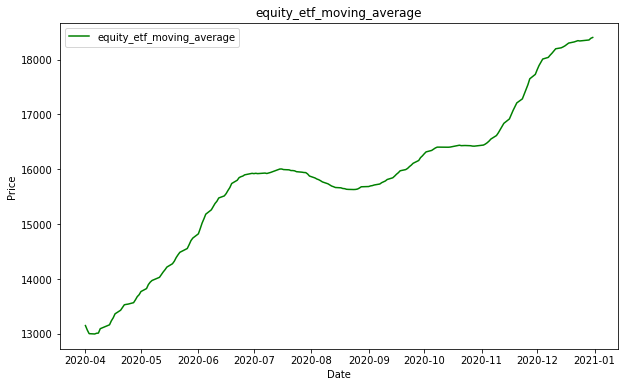

bitcoin moving averages data for 3 quarters


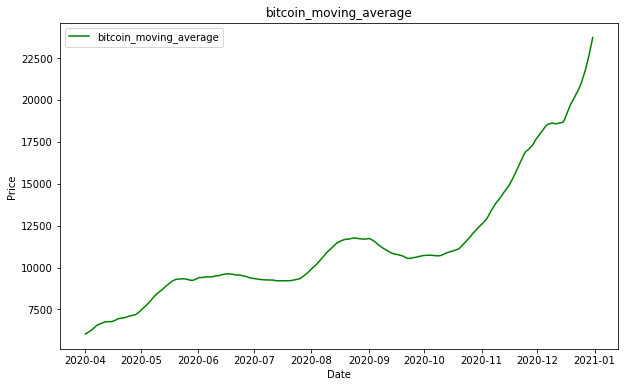

In [73]:
print("gold_etf moving averages data for 3 quarters")
gold_etf_moving_average=get_3_quarters_data(compute_moving_average(gold_etf_3_quarters_with_data_for_moving_average))

fig=plt.figure(figsize=(10,6))
ax1=plt.plot(gold_etf_moving_average.index,gold_etf_moving_average['MovingAvg'],color='green', label='gold_etf_moving_average')
plt.legend()
plt.title("gold_etf_moving_average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


print("equity_etf moving averages data for 3 quarters")
equity_etf_moving_average=get_3_quarters_data(compute_moving_average(equity_etf_3_quarters_with_data_for_moving_average))

fig=plt.figure(figsize=(10,6))
ax1=plt.plot(equity_etf_moving_average.index,equity_etf_moving_average['MovingAvg'],color='green', label='equity_etf_moving_average')
plt.legend()
plt.title("equity_etf_moving_average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


print("bitcoin moving averages data for 3 quarters")
bitcoin_moving_average=get_3_quarters_data(compute_moving_average(bitcoin_3_quarters_with_data_for_moving_average))

fig=plt.figure(figsize=(10,6))
ax1=plt.plot(bitcoin_moving_average.index,bitcoin_moving_average['MovingAvg'],color='green', label='bitcoin_moving_average')
plt.legend()
plt.title("bitcoin_moving_average")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

<h1>4. Graphing</h1>

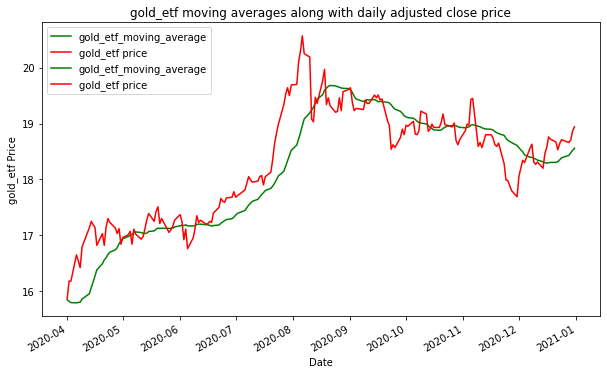

In [74]:
fig=plt.figure(figsize=(10,6))
ax1=gold_etf_moving_average['MovingAvg'].plot(color='green', label='gold_etf_moving_average')
ax2=gold_etf_3_quarters['Adj Close'].plot(color='red', label='gold_etf price')
ax1.set_xlabel("Date")
ax1.set_ylabel("gold_etf moving Average")
ax2.set_xlabel("Date")
ax2.set_ylabel("gold_etf Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("gold_etf moving averages along with daily adjusted close price")
plt.show()

Here we can see the graph intersects in 2 cases. 
 1. when the prices is almost constant, smaller fluctuations make the graph to intersect at various points.
 2. when there is a change in the curvature of the curve from convex to concave or vice versa we see few prominent intersections which indicate the trend reversal. Whenever there is an acceleration provided to the prices in the opposite direction of its current speed then we see that the graph intersects. for example when the prices are going up from 2020-04 to 2020-05 we see no intersection but as soon as the rate of increase goes down to near 0 we see the distance between the graphs close out. after which we see trend from point1. Similar things can be noted around between 2020-08 to 2020-09 where we see a sudden reversal of direction of prices. from going up to going down.
 3. We see when the change in prices is continued in one direction then there are no intersections as the average tries to keep up with the price but is unable to. This is true in the phase when either the price is continuously increasing or continuosly decreasing.

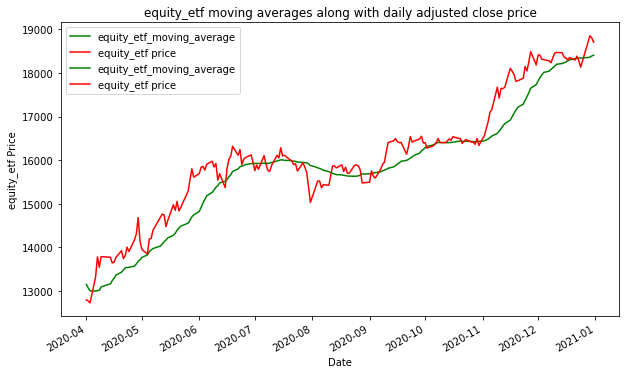

In [75]:
fig=plt.figure(figsize=(10,6))
ax1=equity_etf_moving_average['MovingAvg'].plot(color='green', label='equity_etf_moving_average')
ax2=equity_etf_3_quarters['Adj Close'].plot(color='red', label='equity_etf price')
ax1.set_xlabel("Date")
ax1.set_ylabel("equity_etf moving Average")
ax2.set_xlabel("Date")
ax2.set_ylabel("equity_etf Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("equity_etf moving averages along with daily adjusted close price")
plt.show()

Similar trend has been shown here as explained above with constant increase phase with no intersections till 2020-06 following some intersections from 2020-07 to 2020-09 followed by an intersections each for sudden changes in the trend of the prices. 

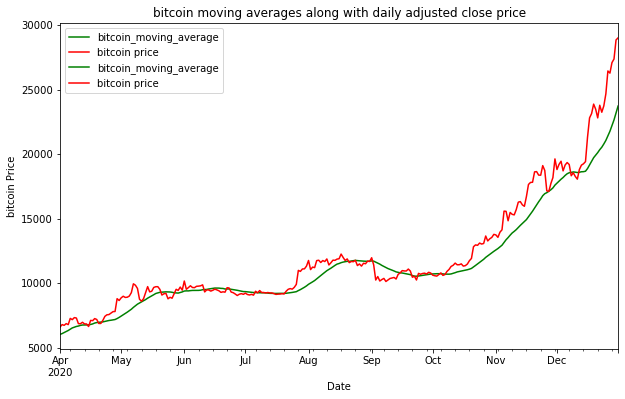

In [76]:
fig=plt.figure(figsize=(10,6))
ax1=bitcoin_moving_average['MovingAvg'].plot(color='green', label='bitcoin_moving_average')
ax2=bitcoin_3_quarters['Adj Close'].plot(color='red', label='bitcoin price')
ax1.set_xlabel("Date")
ax1.set_ylabel("bitcoin moving Average")
ax2.set_xlabel("Date")
ax2.set_ylabel("bitcoin Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("bitcoin moving averages along with daily adjusted close price")
plt.show()

Here we see graph intersects in the starting of Apr followed by phase of constant 0 slope where we see many intersections till August. A sudden spike leads to an intersection around Aug and then we see few intersections around december following exactly the 3 points we have mentioned above.

## Plotting of Prices of pairwise together

Have color coded equity_etf as blue, gold_etf as red and bitcoin as green

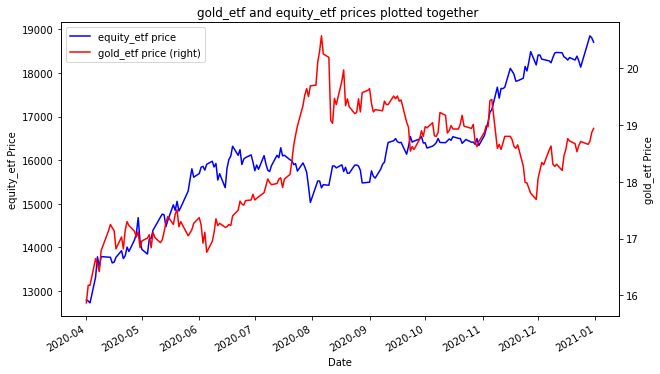

In [77]:
fig=plt.figure(figsize=(10,6))
ax1=equity_etf_3_quarters['Adj Close'].plot(color='blue', label='equity_etf price')
ax2=gold_etf_3_quarters['Adj Close'].plot(color='red',secondary_y=True, label='gold_etf price')
ax1.set_xlabel("Date")
ax1.set_ylabel("equity_etf Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("gold_etf Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("gold_etf and equity_etf prices plotted together ")
plt.show()

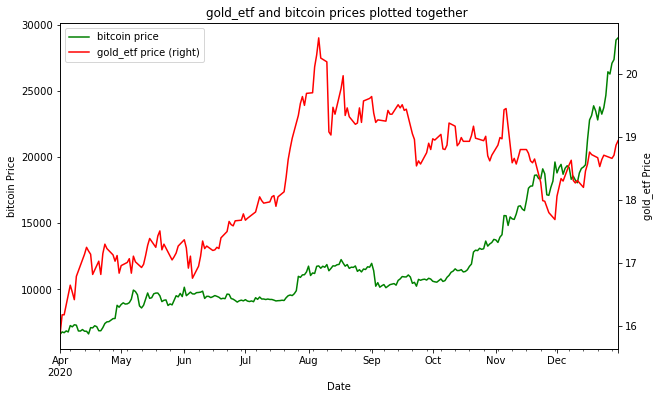

In [78]:
fig=plt.figure(figsize=(10,6))
ax1=bitcoin_3_quarters['Adj Close'].plot(color='green', label='bitcoin price')
ax2=gold_etf_3_quarters['Adj Close'].plot(color='red',secondary_y=True, label='gold_etf price')
ax1.set_xlabel("Date")
ax1.set_ylabel("bitcoin Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("gold_etf Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("gold_etf and bitcoin prices plotted together ")
plt.show()

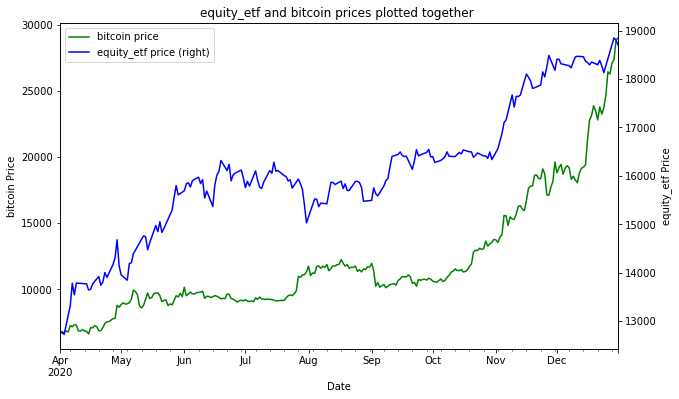

In [79]:
fig=plt.figure(figsize=(10,6))
ax1=bitcoin_3_quarters['Adj Close'].plot(color='green', label='bitcoin price')
ax2=equity_etf_3_quarters['Adj Close'].plot(color='blue',secondary_y=True, label='equity_etf price')
ax1.set_xlabel("Date")
ax1.set_ylabel("bitcoin Price")
ax2.set_xlabel("Date")
ax2.set_ylabel("equity_etf Price")

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.title("equity_etf and bitcoin prices plotted together ")
plt.show()

# 5. Fitting garch models

In [80]:
def fit_garch_model(data,start,end):
    filtered_data=data[data.index.to_series().between(start,end)]
    print("#"*80)
    print("#"*80)
    print("Fitting Garch model for the quarter starting on {} and ending on {}".format(start, end))
    print("#"*80)
    print("#"*80)
    model_garch_1_1=arch_model(filtered_data['Daily_Return'],rescale=True)
    res = model_garch_1_1.fit(update_freq=5)
    print(res.summary())
    #Determining the long-term variance
    omega = res.params["omega"]
    alpha = res.params["alpha[1]"]
    beta = res.params["beta[1]"]
    print("Unconditional variance: {}".format(omega/(1 - alpha - beta)))
    
fit_garch_model(gold_etf_3_quarters[1:],"2020-04-01","2020-07-01")
    
fit_garch_model(gold_etf_3_quarters[1:],"2020-07-01","2020-10-01")
fit_garch_model(gold_etf_3_quarters[1:],"2020-10-01","2021-01-01")

################################################################################
################################################################################
Fitting Garch model for the quarter starting on 2020-04-01 and ending on 2020-07-01
################################################################################
################################################################################
Iteration:      5,   Func. Count:     33,   Neg. LLF: 95.42525341601892
Iteration:     10,   Func. Count:     60,   Neg. LLF: 89.0505386066434
Optimization terminated successfully    (Exit mode 0)
            Current function value: 89.05007614323821
            Iterations: 14
            Function evaluations: 79
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol

In [81]:
def fit_garchm_model(data,start,end):
    filtered_data=data[data.index.to_series().between(start,end)]
    print("#"*80)
    print("#"*80)
    print("Fitting Garch-M model for the quarter starting on {} and ending on {}".format(start, end))
    print("#"*80)
    print("#"*80)
    model_garchm_1_1=ARCHInMean(filtered_data['Daily_Return'],rescale=True,lags=[1,3],volatility=GARCH())
    res = model_garchm_1_1.fit(update_freq=5)
    print(res.summary())
    #Determining the long-term variance
    omega = res.params["omega"]
    alpha = res.params["alpha[1]"]
    beta = res.params["beta[1]"]
    print("Unconditional variance: {}".format(omega/(1 - alpha - beta)))
    
fit_garchm_model(gold_etf_3_quarters[1:],"2020-04-01","2020-07-01")
fit_garchm_model(gold_etf_3_quarters[1:],"2020-07-01","2020-10-01")
fit_garchm_model(gold_etf_3_quarters[1:],"2020-10-01","2021-01-01")

################################################################################
################################################################################
Fitting Garch-M model for the quarter starting on 2020-04-01 and ending on 2020-07-01
################################################################################
################################################################################
Iteration:      5,   Func. Count:     48,   Neg. LLF: 91.4962991887045
Iteration:     10,   Func. Count:     92,   Neg. LLF: 1472.676092971193
Iteration:     15,   Func. Count:    135,   Neg. LLF: 78.79768570779325
Iteration:     20,   Func. Count:    176,   Neg. LLF: 77.97534725256718
Iteration:     25,   Func. Count:    216,   Neg. LLF: 77.7133640661541
Iteration:     30,   Func. Count:    257,   Neg. LLF: 77.57072168779575
Iteration:     35,   Func. Count:    297,   Neg. LLF: 77.40176553240597
Iteration:     40,   Func. Count:    338,   Neg. LLF: 76.99405284432497
Iteration:     4

C:\Users\princ\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(



Iteration:     10,   Func. Count:     87,   Neg. LLF: 89.5051266952093
Iteration:     15,   Func. Count:    140,   Neg. LLF: 88.9838625761385
Iteration:     20,   Func. Count:    182,   Neg. LLF: 88.97449787053111
Iteration:     25,   Func. Count:    222,   Neg. LLF: 88.95379897406833
Iteration:     30,   Func. Count:    264,   Neg. LLF: 88.8159881996761
Iteration:     35,   Func. Count:    305,   Neg. LLF: 88.76603331067801
Iteration:     40,   Func. Count:    346,   Neg. LLF: 96.12254792502071
Iteration:     45,   Func. Count:    389,   Neg. LLF: 88.46739949043055
Iteration:     50,   Func. Count:    429,   Neg. LLF: 88.41863912583992
Iteration:     55,   Func. Count:    475,   Neg. LLF: 88.3794567923864
Iteration:     60,   Func. Count:    516,   Neg. LLF: 88.40393838992962
Iteration:     65,   Func. Count:    558,   Neg. LLF: 88.31582729457743
Iteration:     70,   Func. Count:    601,   Neg. LLF: 88.39895524604258
Iteration:     75,   Func. Count:    642,   Neg. LLF: 88.2856059146

In [82]:
def fit_egarch_model(data,start,end):
    filtered_data=data[data.index.to_series().between(start,end)]
    print("#"*80)
    print("#"*80)
    print("Fitting E-Garch model for the quarter starting on {} and ending on {}".format(start, end))
    print("#"*80)
    print("#"*80)
    model_garch_1_1=arch_model(filtered_data['Daily_Return'],rescale=True,vol="EGARCH")
    res = model_garch_1_1.fit(update_freq=5)
    print(res.summary())
    #Determining the long-term variance
    omega = res.params["omega"]
    alpha = res.params["alpha[1]"]
    beta = res.params["beta[1]"]
    print("Unconditional variance: {}".format(omega/(1 - alpha - beta)))
    
fit_egarch_model(gold_etf_3_quarters[1:],"2020-04-01","2020-07-01")
    
fit_egarch_model(gold_etf_3_quarters[1:],"2020-07-01","2020-10-01")
fit_egarch_model(gold_etf_3_quarters[1:],"2020-10-01","2021-01-01")

################################################################################
################################################################################
Fitting E-Garch model for the quarter starting on 2020-04-01 and ending on 2020-07-01
################################################################################
################################################################################
Iteration:      5,   Func. Count:     33,   Neg. LLF: 89.88949491249839
Iteration:     10,   Func. Count:     63,   Neg. LLF: 25286880.86664093
Iteration:     15,   Func. Count:     92,   Neg. LLF: 87.95251838264912
Iteration:     20,   Func. Count:    119,   Neg. LLF: 282.50244495384186
Iteration:     25,   Func. Count:    149,   Neg. LLF: 117113626.6814393
Iteration:     30,   Func. Count:    181,   Neg. LLF: 85.65298148034306
Iteration:     35,   Func. Count:    208,   Neg. LLF: 85.10262740519998
Iteration:     40,   Func. Count:    234,   Neg. LLF: 84.8506687050352
Optimization t

C:\Users\princ\anaconda3\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 9. The message is:
Iteration limit reached
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


## 6. Assessing stationarity

We'll be using the Augmented Dickey-Fuller Test for stationarity and the data from Quater 2

In [83]:
#Now let's write another function to perform the Augmented Dickey-Fuller test
def perform_adf_test(data):
    quarter_data = data[data.index.to_series().between('2020-04-01', '2020-06-30')]
    result = adfuller(quarter_data['Daily_Return'])
    print('ADF  Statistic : %f' % result[0])
    print('p-value : %f' % result[1])

In [84]:
#Performing the Augmented Dickey-Fuller Test for Quarter on Gold dataset
perform_adf_test(gold_etf_3_quarters[1:])

ADF  Statistic : -2.743241
p-value : 0.066850


Since this p-value very high, the Gold ETF quarter 2 data is not stationary

In [85]:
#Performing Augmented Dickey-Fuller test on Quarter 2 Equity ETF dataset
perform_adf_test(equity_etf_3_quarters[1:])

ADF  Statistic : -5.139627
p-value : 0.000012


This p-value is very low so the series is stationary

In [86]:
#Performing Augmented Dickey-Fuller test on Quarter 2 bitcoin dataset
perform_adf_test(bitcoin_3_quarters[1:])

ADF  Statistic : -6.242239
p-value : 0.000000


This p-value is a strong evidence that the bitcoin quarter 2 data is stationary

## 7. Modelling cointegration

In [87]:
#Getting the data for the quarters 2 and 3
data1 = gold_etf_3_quarters[gold_etf_3_quarters.index<='2020-09-30'].dropna()
data1 = data1['Daily_Return']
data2 = equity_etf_3_quarters[equity_etf_3_quarters.index<='2020-09-30'].dropna()
data2 = data2['Daily_Return']
data3 = bitcoin_3_quarters[bitcoin_3_quarters.index<='2020-09-30'].dropna()
data3 = data3['Daily_Return']

In [88]:
#Merging the dadasets to ensure they have the same length
data = pd.merge(data1, data2, on='Date')
data = pd.merge(data, data3, on='Date')

In [89]:
data

,Daily_Return_x,Daily_Return_y,Daily_Return
Date,,,
2020-04-02,0.019534,-0.001993,0.028281
2020-04-03,0.000000,-0.003328,-0.008867
2020-04-06,0.029048,0.046508,0.070776
2020-04-07,-0.006607,0.034757,-0.013115
2020-04-08,-0.007255,-0.017266,0.021973
...,...,...,...
2020-09-24,0.004315,-0.007768,0.050153
2020-09-25,-0.002685,0.001401,-0.006259
2020-09-28,0.009693,0.002920,-0.006090


In [90]:
data.rename(columns = {'Daily_Return_x':'gold_return', 'Daily_Return_y':'equity_return', 'Daily_Return':'bitcoin_return'}, inplace = True)
data

,gold_return,equity_return,bitcoin_return
Date,,,
2020-04-02,0.019534,-0.001993,0.028281
2020-04-03,0.000000,-0.003328,-0.008867
2020-04-06,0.029048,0.046508,0.070776
2020-04-07,-0.006607,0.034757,-0.013115
2020-04-08,-0.007255,-0.017266,0.021973
...,...,...,...
2020-09-24,0.004315,-0.007768,0.050153
2020-09-25,-0.002685,0.001401,-0.006259
2020-09-28,0.009693,0.002920,-0.006090


#### Johansen cointegration test

In [91]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [92]:
cointegration_test(data)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
gold_return ::  68.41     > 24.2761   =>   True
equity_return ::  26.07     > 12.3212   =>   True
bitcoin_return ::  11.18     > 4.1296    =>   True


In [93]:
cointegration_test(data[['gold_return','equity_return']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
gold_return ::  49.27     > 12.3212   =>   True
equity_return ::  14.53     > 4.1296    =>   True


In [94]:
cointegration_test(data[['equity_return','bitcoin_return']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
equity_return ::  42.04     > 12.3212   =>   True
bitcoin_return ::  11.43     > 4.1296    =>   True


In [95]:
cointegration_test(data[['bitcoin_return','gold_return']])

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
bitcoin_return ::  31.43     > 12.3212   =>   True
gold_return ::  10.46     > 4.1296    =>   True


This code is self-explanatory - when Signif is true it means there exists cointegration equation when is true for all the above cases.

### Cointegration using the Engle-Granger test

In [96]:
#Let's use the Engle-Granger test now
gold = data['gold_return']
equity = data['equity_return']
bitcoin = data['bitcoin_return']
print("Results for the Gold-Equity")
engle_granger(gold, equity, trend="n")

Results for the Gold-Equity


Test Statistic,-11.930
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.070


In [97]:
print("Results for the Equity-Bitcoin")
engle_granger(equity, bitcoin, trend="n")

Results for the Equity-Bitcoin


Test Statistic,-11.179
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.018


In [98]:
print("Results for the Bitcoin-Gold")
engle_granger(bitcoin, gold, trend="n")

Results for the Bitcoin-Gold


Test Statistic,-12.408
P-value,0.000
ADF Lag length,0
Estimated Root ρ (γ+1),-0.120


Both test lead to the same conclusion: The series are cointegrated

### Vector Error Correction Model

In [99]:
vec_rank1 = select_coint_rank(data, det_order = 1, k_ar_diff = 1, method = 'trace', signif=0.01)
print(vec_rank1.summary())

Johansen cointegration test using trace test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          165.9          41.08
  1   3          96.39          23.15
  2   3          43.47          6.635
-------------------------------------


In [100]:
vec_rank = select_coint_rank(data, det_order = 1, k_ar_diff = 1, method = 'maxeig', signif=0.01)
print(vec_rank.summary())

Johansen cointegration test using maximum eigenvalue test statistic with 1% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   1          69.55          29.26
  1   2          52.92          21.75
  2   3          43.47          6.635
-------------------------------------


SInce for all the test_statistic > critical value  so the null of at most one co-integrating vector can be rejected.

In [101]:
data.index = pd.DatetimeIndex(data.index).to_period('M')

In [102]:
#Getting the data for the quarter 4
data1 = gold_etf_3_quarters[gold_etf_3_quarters.index>'2020-09-30'].dropna()
data1 = data1['Daily_Return']
data2 = equity_etf_3_quarters[equity_etf_3_quarters.index>'2020-09-30'].dropna()
data2 = data2['Daily_Return']
data3 = bitcoin_3_quarters[bitcoin_3_quarters.index>'2020-09-30'].dropna()
data3 = data3['Daily_Return']

#Merging the dadasets to ensure they have the same length
data_Q4 = pd.merge(data1, data2, on='Date')
data_Q4 = pd.merge(data_Q4, data3, on='Date')

In [103]:
lags=15
vecm = VECM(endog = data, k_ar_diff = lags, coint_rank = 3, deterministic = 'ci')
vecm_fit = vecm.fit()
vecm_fit.predict(steps=10)
forecast, lower, upper = vecm_fit.predict(63, 0.05)
forecast=pd.DataFrame(forecast)
forecast.index=data_Q4.index

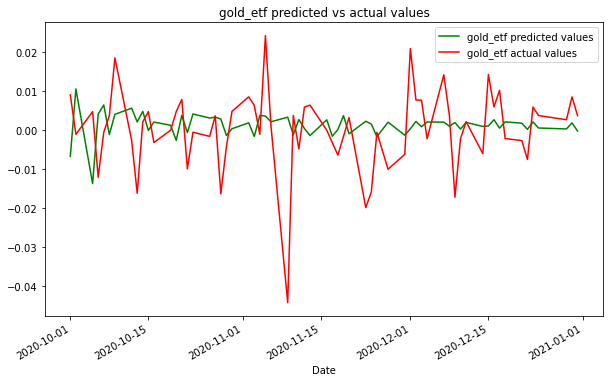

In [104]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[0].plot(color='green', label='gold_etf predicted values');
ax2=data_Q4['Daily_Return_x'].plot(color='red', label='gold_etf actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("gold_etf predicted vs actual values")
plt.show()

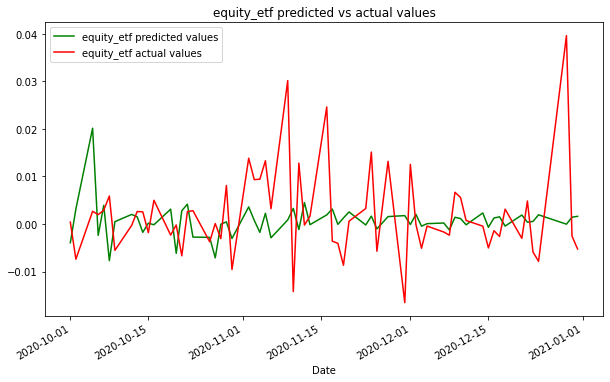

In [105]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[1].plot(color='green', label='equity_etf predicted values');
ax2=data_Q4['Daily_Return_y'].plot(color='red', label='equity_etf actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("equity_etf predicted vs actual values")
plt.show()

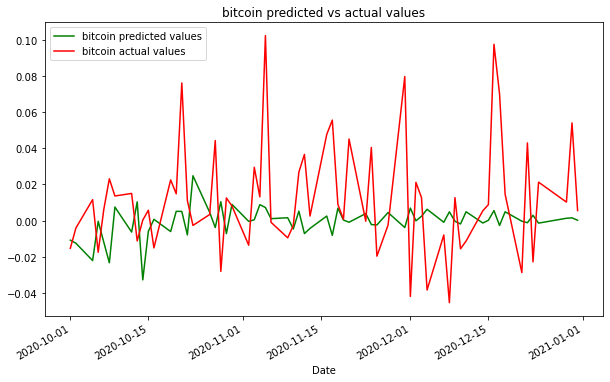

In [106]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[2].plot(color='green', label='bitcoin predicted values');
ax2=data_Q4['Daily_Return'].plot(color='red', label='bitcoin actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("bitcoin predicted vs actual values")
plt.show()

The predictions excellent as we can see on the above graphs

### Vector AutoRegressive Model

To select the right order of the VAR model, we iteratively fit increasing orders of VAR model and pick the order that gives a model with least AIC.

In [107]:
#Initiate VAR model
model = VAR(endog=data)
res = model.select_order(15)
res.summary()

,AIC,BIC,FPE,HQIC
0,-25.01*,-24.93*,1.380e-11*,-24.98*
1,-24.90,-24.60,1.536e-11,-24.78
2,-24.89,-24.37,1.547e-11,-24.68
3,-24.83,-24.09,1.641e-11,-24.53
4,-24.77,-23.80,1.758e-11,-24.38
5,-24.73,-23.54,1.835e-11,-24.24
6,-24.73,-23.31,1.839e-11,-24.16
7,-24.76,-23.12,1.805e-11,-24.09
8,-24.63,-22.76,2.069e-11,-23.87
9,-24.67,-22.58,2.008e-11,-23.82


we see AIC reduces till lag 5 so we'll be using that as the lag in our analysis further

In [108]:
lags=15
results=model.fit(lags)

In [109]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 20, Apr, 2022
Time:                     22:42:28
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -21.1497
Nobs:                     108.000    HQIC:                  -23.1873
Log likelihood:           1005.42    FPE:                2.52303e-11
AIC:                     -24.5769    Det(Omega_mle):     8.70225e-12
--------------------------------------------------------------------
Results for equation gold_return
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                      0.001804         0.001820            0.991           0.321
L1.gold_return            -0.097714         0.149114           -0.655           0.512
L1.equity_return          -0.09816

In the equation for gold_return, no lag is significant at the 5% level and only L2.gold_return, L6.gold_return,  L7.equity_return are sifnificant at 10% level

In the equation for equity return, the lags L1.gold_return, L5.equity_return, L6.equity_return, L7.bitcoin_return, L8.equity_return, L9.bitcoin_return, L10.bitcoin_return, L14.equity_return and L15.bitcoin_return are significant at 5% level and can used in the modeling

For the equation for bitcoin_return, only the lags L2.equity_return and L10.gold_return are significant at 5% level and should be included in the modeling

##### Checking for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic
Serial correlation of residuals is used to check if there is any leftover pattern in the residuals (errors). A common way of checking for serial correlation of errors is by using the Durbin Watson’s Statistic.

In [110]:
out = durbin_watson(results.resid)
print(out)

[1.97906665 2.05459393 1.89366804]


The serial correlation seems quite alright. Let’s proceed with the forecast.

In [111]:
forecast=results.forecast(y=data.values[-lags:],steps=63)
forecast=pd.DataFrame(forecast)
forecast.index=data_Q4.index

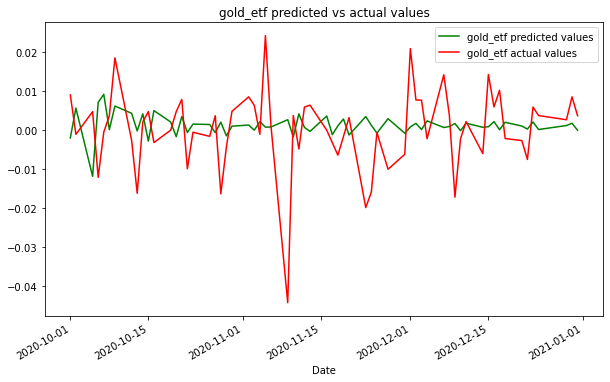

In [112]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[0].plot(color='green', label='gold_etf predicted values');
ax2=data_Q4['Daily_Return_x'].plot(color='red', label='gold_etf actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("gold_etf predicted vs actual values")
plt.show()

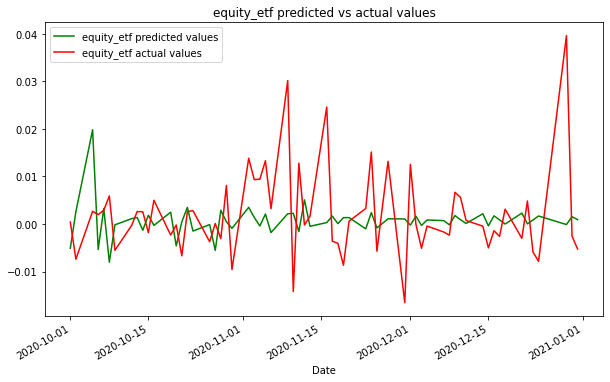

In [113]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[1].plot(color='green', label='equity_etf predicted values');
ax2=data_Q4['Daily_Return_y'].plot(color='red', label='equity_etf actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("equity_etf predicted vs actual values")
plt.show()

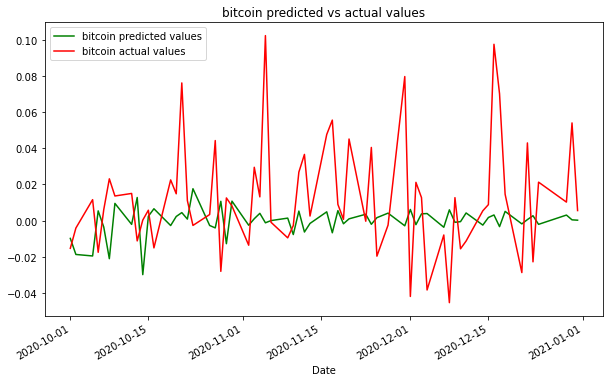

In [114]:
fig=plt.figure(figsize=(10,6))
ax1=forecast[2].plot(color='green', label='bitcoin predicted values');
ax2=data_Q4['Daily_Return'].plot(color='red', label='bitcoin actual values');
ax1.set_xlabel("Date")
ax2.set_xlabel("Date")
plt.legend()
plt.title("bitcoin predicted vs actual values")
plt.show()

Here we can see the results by the model in the plot for every variable. The lines for forecasted values are going in such a steady manner, so here we can see the lags we have decided are quite satisfactory and providing good results.